<a href="https://colab.research.google.com/github/eferos93/sml_project/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_files
import torch.optim as optim
import os
import numpy as np
import time
from PIL import Image
from torchvision.utils import make_grid
from torchvision import datasets,transforms
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import copy
from glob import glob

In [4]:
!unzip drive/My\ Drive/5857_1166105_bundle_archive

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360/Training/Tomato 3/125_100.jpg  
  inflating: fruits-360/Training/Tomato 3/126_100.jpg  
  inflating: fruits-360/Training/Tomato 3/127_100.jpg  
  inflating: fruits-360/Training/Tomato 3/128_100.jpg  
  inflating: fruits-360/Training/Tomato 3/129_100.jpg

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
path = '/content/fruits-360/'
files_training = glob(os.path.join(path,'Training', '*/*.jpg'))
num_images = len(files_training)
print('Number of images in Training file:', num_images)

Number of images in Training file: 67692


In [7]:
os.getcwd()
glob(os.path.join(path,'Training', '*/*.jpg'))
os.path.join(path,'Training', '*/*.jpg')

'/content/fruits-360/Training/*/*.jpg'

In [8]:
min_images = 1000
im_cnt = []
class_names = []
print('{:18s}'.format('class'), end='')
print('Count:')
print('-' * 24)
for folder in os.listdir(os.path.join(path, 'Training')):
    folder_num = len(os.listdir(os.path.join(path,'Training',folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
    if (folder_num < min_images):
        min_images = folder_num
        folder_name = folder
        
num_classes = len(class_names)
print("\nMinumum imgages per category:", min_images, 'Category:', folder)    
print('Average number of Images per Category: {:.0f}'.format(np.array(im_cnt).mean()))
print('Total number of classes: {}'.format(num_classes))

class             Count:
------------------------
Cherry Wax Black     492
Banana Lady Finger   450
Potato White         450
Grapefruit White     492
Physalis             492
Salak                490
Tomato 4             479
Huckleberry          490
Orange               479
Chestnut             450
Lemon Meyer          490
Grape Pink           492
Tomato Heart         684
Apple Crimson Snow   444
Mangostan            300
Plum                 447
Limes                490
Watermelon           475
Cantaloupe 2         492
Peach Flat           492
Papaya               492
Maracuja             490
Tomato 2             672
Apple Red Delicious  490
Cherry 1             492
Kohlrabi             471
Tomato Cherry Red    492
Plum 2               420
Eggplant             468
Tomato 3             738
Grape White 3        492
Pepper Red           666
Pineapple            490
Grape Blue           984
Melon Piel de Sapo   738
Peach                492
Cocos                490
Kaki                 490


In [10]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

all_data = ImageFolder(os.path.join(path, 'Training'), tensor_transform)

In [11]:
data_loader = torch.utils.data.DataLoader(all_data, batch_size=512, shuffle=True)

In [12]:
pop_mean = []
pop_std = []

for i, data in enumerate(data_loader, 0):
    numpy_image = data[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    
    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

pop_mean = np.array(pop_mean).mean(axis=0)
pop_std = np.array(pop_std).mean(axis=0)

print(pop_mean)
print(pop_std)

[0.68403256 0.5785967  0.5037142 ]
[0.3033625  0.35993466 0.3914074 ]


In [13]:
np.random.seed(123)
shuffle = np.random.permutation(num_images)

In [14]:
split_val = int(num_images * 0.2)
print('Total number of images:', num_images)
print('Number of valid images after split:',len(shuffle[:split_val]))
print('Number of train images after split:',len(shuffle[split_val:]))

Total number of images: 67692
Number of valid images after split: 13538
Number of train images after split: 54154


In [15]:
class FruitTrainDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[split_val:]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

class FruitValidDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[:split_val]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y
    
class FruitTestDataset(Dataset):
    def __init__(self, path, class_names, transform=transforms.ToTensor()):
        self.class_names = class_names
        self.data = np.array(glob(os.path.join(path, '*/*.jpg')))
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'Test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ])
}

train_dataset = FruitTrainDataset(files_training, shuffle, split_val, class_names, data_transforms['train'])
valid_dataset = FruitValidDataset(files_training, shuffle, split_val, class_names, data_transforms['valid'])
test_dataset = FruitTestDataset('/content/fruits-360/Test', class_names, transform=data_transforms['Test'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [17]:
dataloaders = {'train': train_loader,
              'valid': valid_loader,
              'Test': test_loader}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'Test': len(test_dataset)
}

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = pop_std * inp + pop_mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

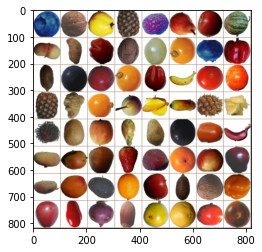

['Huckleberry', 'Walnut', 'Quince', 'Pineapple', 'Raspberry', 'Pear Red', 'Apple Braeburn', 'Watermelon', 'Peach Flat', 'Potato Sweet', 'Tomato Heart', 'Cocos', 'Grape White', 'Physalis', 'Huckleberry', 'Pepper Red', 'Nut Pecan', 'Grape Blue', 'Pomegranate', 'Physalis', 'Tomato Heart', 'Banana Lady Finger', 'Tomato Cherry Red', 'Clementine', 'Pineapple', 'Ginger Root', 'Physalis', 'Pear 2', 'Carambula', 'Banana Lady Finger', 'Pineapple Mini', 'Physalis with Husk', 'Rambutan', 'Kiwi', 'Apple Pink Lady', 'Cactus fruit', 'Potato White', 'Grape Blue', 'Pepper Orange', 'Banana Red', 'Peach Flat', 'Papaya', 'Nut Forest', 'Strawberry', 'Salak', 'Grapefruit Pink', 'Apple Braeburn', 'Apple Red Delicious', 'Potato Red', 'Apricot', 'Avocado ripe', 'Lemon Meyer', 'Apple Braeburn', 'Nut Pecan', 'Walnut', 'Pepper Yellow', 'Cherry 2', 'Tomato 2', 'Onion Red Peeled', 'Hazelnut', 'Maracuja', 'Grapefruit White', 'Kaki', 'Tomato Maroon']


In [19]:
inputs, classes = next(iter(train_loader))
out = make_grid(inputs)

cats = ['' for x in range(len(classes))]
for i in range(len(classes)):
    cats[i] = class_names[classes[i].item()]
    
imshow(out)
print(cats)

# Network

In [ ]:
model = torchvision.models.vgg11(num_classes)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
exp_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


In [20]:
def train(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time() # allows us to keep track of how long it took
    
    best_acc = 0.0 # allows us to store the best_acc rate (for validation stage)
    
    # Loop through the data-set num_epochs times.
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 15)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train() # This sets the model to training mode
            else:
                model.eval() # this sets the model to evaluation mode 
                
            running_loss = 0.0
            running_corrects = 0
            
            # using the dataloaders to load data in batches
            for inputs, labels in dataloaders[phase]:
                # putting the inputs and labels on cuda (gpu)
                inputs = inputs.to(device) 
                labels = labels.to(device)
                
                # zero the gradient
                optimizer.zero_grad()
                
                # if training phase, allow calculating the gradient, but don't allow otherwise
                with torch.set_grad_enabled(phase == 'train'):
                    # get outputs and predictions
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels) # get value of loss function with the current weights 
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # keep track of the best weights for the validation dataset 
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = train(model, criterion, optimizer,
                         exp_scheduler, num_epochs=30)

Epoch 0/29
---------------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.4281 Acc: 0.6859
valid Loss: 0.1653 Acc: 0.9734

Epoch 1/29
---------------
train Loss: 0.0528 Acc: 0.9848
valid Loss: 0.0116 Acc: 0.9965

Epoch 2/29
---------------
train Loss: 0.0184 Acc: 0.9946
valid Loss: 0.0014 Acc: 0.9996

Epoch 3/29
---------------
train Loss: 0.0278 Acc: 0.9940
valid Loss: 0.0005 Acc: 0.9999

Epoch 4/29
---------------
train Loss: 0.0065 Acc: 0.9984
valid Loss: 0.0003 Acc: 1.0000

Epoch 5/29
---------------
train Loss: 0.0046 Acc: 0.9988
valid Loss: 0.0001 Acc: 1.0000

Epoch 6/29
---------------
train Loss: 0.0018 Acc: 0.9997
valid Loss: 0.0001 Acc: 1.0000

Epoch 7/29
---------------
train Loss: 0.0013 Acc: 0.9997
valid Loss: 0.0000 Acc: 1.0000

Epoch 8/29
---------------
train Loss: 0.0014 Acc: 0.9996
valid Loss: 0.0000 Acc: 1.0000

Epoch 9/29
---------------
train Loss: 0.0009 Acc: 0.9999
valid Loss: 0.0000 Acc: 1.0000

Epoch 10/29
---------------
train Loss: 0.0010 Acc: 0.9998
valid Loss: 0.0000 Acc: 1.0000

Epoch 11/29
---------------
train Lo

In [1]:
def get_accuracy(model):
  correct = 0
  total = 0
  with torch.no_grad():
      for images, labels in dataloaders['Test']:
          images = images.to(device)
          labels = labels.to(device)
          
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the {} test images: {:.3f}%'.format(dataset_sizes['Test'], 
                                                                        100 * correct / dataset_sizes['Test']))

## ResNet


In [22]:
model_resnet = torchvision.models.resnet18(num_classes) #https://arxiv.org/abs/1512.03385
model_resnet.to(device)

optimizer = optim.SGD(model_resnet.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
exp_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_resnet = train(model_resnet, criterion, optimizer, exp_scheduler)

Epoch 0/29
---------------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.4125 Acc: 0.9390
valid Loss: 0.0155 Acc: 0.9980

Epoch 1/29
---------------
train Loss: 0.0121 Acc: 0.9992
valid Loss: 0.2395 Acc: 0.9413

Epoch 2/29
---------------
train Loss: 0.0071 Acc: 0.9995
valid Loss: 0.0022 Acc: 0.9999

Epoch 3/29
---------------
train Loss: 0.0043 Acc: 0.9999
valid Loss: 1.5686 Acc: 0.7079

Epoch 4/29
---------------
train Loss: 0.0081 Acc: 0.9991
valid Loss: 0.0010 Acc: 1.0000

Epoch 5/29
---------------
train Loss: 0.0027 Acc: 0.9999
valid Loss: 0.0009 Acc: 0.9999

Epoch 6/29
---------------
train Loss: 0.0023 Acc: 1.0000
valid Loss: 0.0007 Acc: 1.0000

Epoch 7/29
---------------
train Loss: 0.0022 Acc: 0.9999
valid Loss: 0.0006 Acc: 1.0000

Epoch 8/29
---------------
train Loss: 0.0022 Acc: 0.9999
valid Loss: 0.0006 Acc: 1.0000

Epoch 9/29
---------------
train Loss: 0.0021 Acc: 1.0000
valid Loss: 0.0006 Acc: 1.0000

Epoch 10/29
---------------
train Loss: 0.0021 Acc: 0.9999
valid Loss: 0.0005 Acc: 1.0000

Epoch 11/29
---------------
train Lo

In [3]:
get_accuracy(model_resnet)

NameError: ignored

In [ ]:
model_resNext = models.resnext50_32x4d()

In [ ]:
model_resNext = train(model_resNext, criterion,optimizer, exp_scheduler)